## Selección del Área para el Parque Nacional Cerro Saroche

**PROYECTO:** SISTEMA PARA EL SEGUIMIENTO DE ECOSISTEMAS VENEZOLANOS \
**AUTOR:** Javier Martinez

In [17]:
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab

In [18]:
import warnings
warnings.filterwarnings('ignore')

#### Polígono del parque y Google Earth Engine

* Implementación de Google Earth Engine para descargar el polígono del parque nacional.

In [19]:
import ee
import numpy as np

# iniciando ee
ee.Initialize()

# parque
polygonCollection = 'WCMC/WDPA/current/polygons'
polygonName = 'Cerro Saroche'

# poligono
polygon = ee.FeatureCollection(polygonCollection) \
            .filter(ee.Filter.eq('NAME', polygonName))

# projection del poligono
polygon.geometry().projection().getInfo()

{'type': 'Projection', 'crs': 'EPSG:4326', 'transform': [1, 0, 0, 0, 1, 0]}

#### Creando Objeto Geopandas

* Utilización de Geopandas para crear el polígono.

In [20]:
import json
import geopandas

# lectura en geopandas
geoJson_polygon = json.dumps( polygon.geometry().getInfo() )
geopandas_polygon = geopandas.read_file(geoJson_polygon)
geopandas_polygon.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [21]:
import topojson

f_open = open('./venezuela/poligonos/venezuela_country.json')
venezuela_topojson = json.loads(f_open.read())
f_open.close()

venezuela_geojson = topojson.Topology(venezuela_topojson, object_name="VEN_adm1").to_geojson()
venezuela_geopandas = geopandas.read_file(venezuela_geojson)
venezuela_geopandas.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

#### Proyección precipitación

* Aplicando proyección de la precipitación.

In [22]:
from pyproj.crs import CRS

precipitacion_crs = CRS.from_wkt('GEOGCS["Coordinate System imported from GRIB file",DATUM["unnamed",SPHEROID["Sphere",6367470,0]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST]]')

park_poligono = geopandas_polygon.to_crs(precipitacion_crs)
park_poligono.crs

<Geographic 2D CRS: GEOGCS["Coordinate System imported from GRIB file" ...>
Name: Coordinate System imported from GRIB file
Axis Info [ellipsoidal]:
- lat[north]: Latitude (degree)
- lon[east]: Longitude (degree)
Area of Use:
- undefined
Datum: unnamed
- Ellipsoid: Sphere
- Prime Meridian: Greenwich

In [23]:
venezuela_poligonos = venezuela_geopandas.to_crs(precipitacion_crs)
venezuela_poligonos.crs

<Geographic 2D CRS: GEOGCS["Coordinate System imported from GRIB file" ...>
Name: Coordinate System imported from GRIB file
Axis Info [ellipsoidal]:
- lat[north]: Latitude (degree)
- lon[east]: Longitude (degree)
Area of Use:
- undefined
Datum: unnamed
- Ellipsoid: Sphere
- Prime Meridian: Greenwich

In [24]:
# guardando poligono
park_poligono.to_file("./cerro_saroche/poligono_cerro_saroche/cerro_saroche.shp")
venezuela_poligonos.to_file("./venezuela/poligonos/venezuela.shp")

In [25]:
park_poligono.geometry.iloc[0].bounds

(-69.87736418641249,
 10.062336113372258,
 -69.41036257819223,
 10.301896801621677)

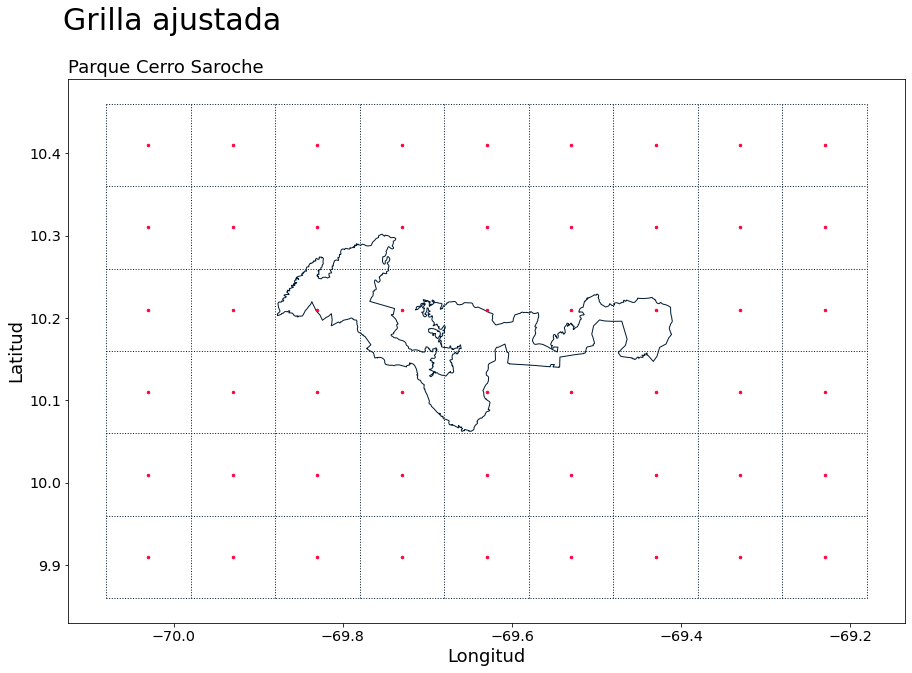

In [26]:
# centros
x = np.arange(-70.13,-69.13,0.1)
y = np.arange(9.81,10.51,0.1)

# grilla
x_grid = x + 0.05
y_grid  = y + 0.05

# plot
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(1, 1, 1)

params = {'legend.fontsize': 'x-large',
          #'figure.figsize': (15, 10),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

# poligono
x1,y1 = park_poligono.geometry.iloc[0].exterior.xy
ax.plot(x1,y1, color='#001B32', linewidth=1)

for i in list(range(1, len(x) )):
  for j in list(range(1, len(y) )):
    ax.plot(x[i],y[j],color = '#FF003E', marker='.', label=i, markersize=5)


color_grid = '#001B32'
# grilla
for i in list(range( len(x_grid) )):
  ax.vlines(x = x_grid[i],ymin=min(y_grid),ymax=max(y_grid),
            colors = color_grid,
            linestyles='dotted',
            linewidth=1,
            label = 'vline_multiple - full height')

for i in list(range( len(y_grid) )):
  ax.hlines(y = y_grid[i],xmin=min(x_grid),xmax=max(x_grid),
            colors = color_grid,
            linestyles='dotted',
            linewidth=1,
            label = 'vline_multiple - full height')

plt.title("Parque Cerro Saroche",loc='left',fontsize=18)
plt.suptitle(f"Grilla ajustada",ha='left',fontsize=30,x=0.12)
plt.xlabel("Longitud",loc='center',fontsize=18)
plt.ylabel("Latitud",loc='center',fontsize=18)

plt.savefig('./cerro_saroche/figuras/grilla_ajustada_precipitacion1.png')

plt.show()

#### Generando rectángulo

* Creando región de estudio como polígono con la proyección de la precipitación.

In [27]:
# Rectangulo definido al parque
from shapely.geometry import Polygon

poligono = Polygon([
                  (-69.88, 10.06),
                  (-69.88, 10.36),
                  (-69.38, 10.36),
                  (-69.38, 10.06),
                  (-69.88, 10.06)
                        ])

parque_rectangulo = geopandas.GeoSeries(poligono, crs = precipitacion_crs)
parque_rectangulo.crs

<Geographic 2D CRS: GEOGCS["Coordinate System imported from GRIB file" ...>
Name: Coordinate System imported from GRIB file
Axis Info [ellipsoidal]:
- lat[north]: Latitude (degree)
- lon[east]: Longitude (degree)
Area of Use:
- undefined
Datum: unnamed
- Ellipsoid: Sphere
- Prime Meridian: Greenwich

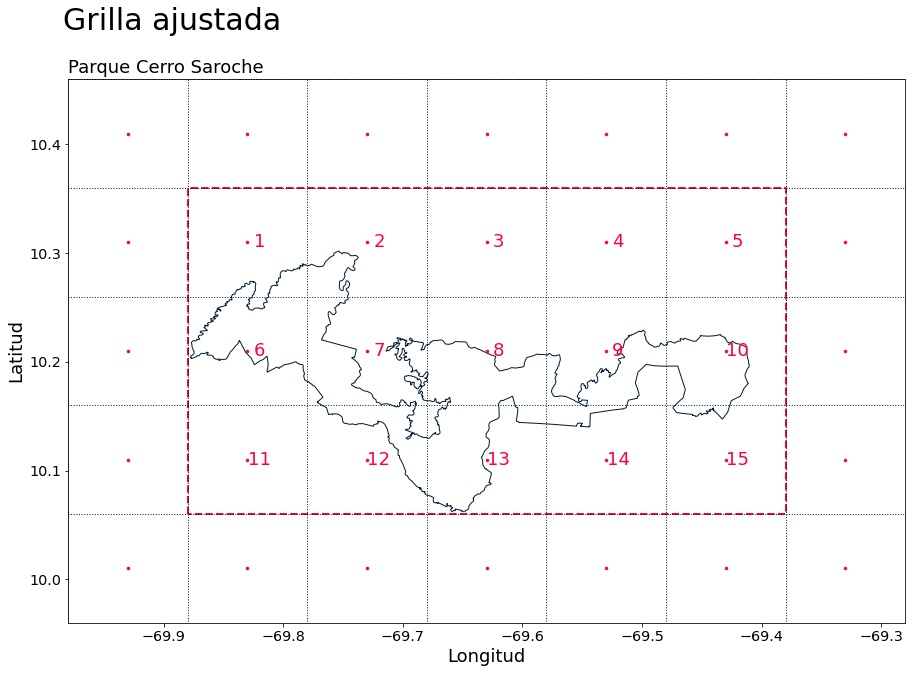

In [28]:
# centros
x = np.arange(-70.13,-69.13,0.1)
y = np.arange(9.81,10.51,0.1)

# grilla
x_grid = x + 0.05
y_grid  = y + 0.05

# plot
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(1, 1, 1)

params = {'legend.fontsize': 'x-large',
          #'figure.figsize': (15, 10),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

# poligonos
x1,y1 = park_poligono.geometry.iloc[0].exterior.xy
ax.plot(x1,y1, color='#001B32', linewidth=1)

x2,y2 = parque_rectangulo.geometry.iloc[0].exterior.xy
ax.plot(x2,y2, color='#FF003E', linewidth=2,linestyle='dashed')

# centroides
annotate = 1
annotate_list = 15*[0]+[11,6,1]+3*[0]+[12,7,2]+3*[0]+[13,8,3]+3*[0]+[14,9,4]+3*[0]+[15,10,5]+30*[0]
for i in list(range(1, len(x) )):
  for j in list(range(1, len(y) )):
    ax.plot(x[i],y[j],color = '#FF003E', marker='.', label=i, markersize=5)
    if annotate_list[annotate]!=0:
      ax.annotate(str(annotate_list[annotate]),  xy=(x[i]+0.01,y[j]), color='#FF003E',
          fontsize=18, #weight='',
          horizontalalignment='center',
          verticalalignment='center')
    annotate+=1

# grilla
color_grid = '#001B32'
for i in list(range( len(x_grid) )):
  ax.vlines(x = x_grid[i],ymin=min(y_grid),ymax=max(y_grid),
            colors = color_grid,
            linestyles='dotted',
            linewidth=1,
            label = 'vline_multiple - full height')

for i in list(range( len(y_grid) )):
  ax.hlines(y = y_grid[i],xmin=min(x_grid),xmax=max(x_grid),
            colors = color_grid,
            linestyles='dotted',
            linewidth=1,
            label = 'vline_multiple - full height')

# titulos
plt.title("Parque Cerro Saroche",loc='left',fontsize=18)
plt.suptitle(f"Grilla ajustada",ha='left',fontsize=30,x=0.12)
plt.xlabel("Longitud",loc='center',fontsize=18)
plt.ylabel("Latitud",loc='center',fontsize=18)
plt.xlim([-69.98, -69.28])
plt.ylim([9.96, 10.46])


# guardando figura
plt.savefig('./cerro_saroche/figuras/grilla_ajustada_precipitacion2.png')

plt.show()

In [29]:
# guardando poligono
parque_rectangulo.to_file("./cerro_saroche/poligono_cerro_saroche/rectangulo_cerro_saroche.shp")

#### Visualización Cerro Saroche

In [30]:
import pandas as pd

rdf = pd.concat([geopandas.GeoDataFrame(park_poligono,crs=precipitacion_crs),
                 geopandas.GeoDataFrame(geometry=parque_rectangulo,crs=precipitacion_crs)
                ],0,ignore_index=True)
rdf

,geometry
0,"POLYGON ((-69.87736 10.20384, -69.87701 10.203..."
1,"POLYGON ((-69.88000 10.06000, -69.88000 10.360..."


In [31]:
map = park_poligono.explore(legend=False,color='#001B32')
map.save('./cerro_saroche/figuras/park_poligon_leaflet.html')